# 3 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

The objectives of this notebook is to create a machine learning capable to segmentize a given Tweet into its category. We will be using word embedding to define the clusters of the tweets. Word Embedding is a language modeling technique used for mapping words to vectors of real numbers. It represents words or phrases in vector space with several dimensions.

Guidance from Springboard:
* Create dummy or indicator features for categorical variables
* Standardize the magnitude of numeric features using a scaler
* Split your data into testing and training datasets

## 3.1 Imports<a id='4.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
import re

In [2]:
#Importing stock data from previous notebook "02_Exploratory_Data_Analysis"
eda_stock_data = pd.read_csv('/Users/user/Documents/Springboard_Data_Science/Capstone_2_Twitter_Sentiment_Analysis/Data/eda_stock_data.csv', encoding='latin-1')
eda_stock_data.reset_index(drop=True, inplace=True)
eda_stock_data.head()

,Dates,Time,Volume,%_change_Open,%_change_High,%_change_Low,%_change_Close,%_change_Volume
0,2022-10-03,00:00:00,114311700,NaN,NaN,NaN,NaN,NaN
1,2022-10-04,00:00:00,87830100,4.934514,2.201715,4.771583,2.562311,-23.166133
2,2022-10-05,00:00:00,79471000,-0.661926,0.793328,-0.866491,0.205326,-9.517352
3,2022-10-06,00:00:00,68402200,1.207739,0.108555,1.545351,-0.662562,-13.928100
4,2022-10-07,00:00:00,85925600,-2.242648,-3.009345,-3.973285,-3.671873,25.618182


In [3]:
#Importing tweet data from previous notebook "02_Exploratory_Data_Analysis"
trading_hours_tweets = pd.read_csv('/Users/user/Documents/Springboard_Data_Science/Capstone_2_Twitter_Sentiment_Analysis/Data/trading_hours_tweets.csv', encoding='latin-1')
trading_hours_tweets.head()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis
0,2022-10-04,20:29:10,BarbaraDarlin,0,Tweetbot for iÎS,.@apple needs to do this WORLDWIDE! https://t....,0.000000,0.000000,Neutral
1,2022-10-04,20:29:03,Options,0,StockTwits Web,"#HotOptions Report For End Of Day, October 4, ...",0.000000,0.000000,Neutral
2,2022-10-04,20:27:59,IGSquawk,8,TweetDeck,FANG+ Constituents:\n\n$AAPL 146.04 +2.52%\n$A...,0.000000,0.000000,Neutral
3,2022-10-04,20:27:54,breckyunits,0,Twitter Web App,I gave this talk in 2017 at @forwardJS . They ...,0.633333,-0.366667,Negative
4,2022-10-04,20:27:11,emilesmithjoe,0,Twitter for iPhone,@Apple make a cannon emoji. Thank you,0.000000,0.000000,Neutral


In [4]:
trading_hours_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80484 entries, 0 to 80483
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Dates         80484 non-null  object 
 1   Time          80473 non-null  object 
 2   user          80473 non-null  object 
 3   likes         80473 non-null  object 
 4   source        80460 non-null  object 
 5   text          80460 non-null  object 
 6   Subjectivity  80447 non-null  float64
 7   Polarity      80447 non-null  float64
 8   Analysis      80447 non-null  object 
dtypes: float64(2), object(7)
memory usage: 5.5+ MB


In [5]:
trading_hours_tweets.dtypes

Dates            object
Time             object
user             object
likes            object
source           object
text             object
Subjectivity    float64
Polarity        float64
Analysis         object
dtype: object

In [6]:
trading_hours_tweets[trading_hours_tweets.isna().any(axis=1)]

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis
206,2022-10-04,20:00:52,topstonks,0,topstonks,$AAPL seeing an uptick in chatter on wallstree...,NaN,NaN,NaN
207,Via https://t.co/DoXFBxbWjw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,#aapl #wallstreetbets #investors https://t...,0.0666666666666666,0.0,Neutral,NaN,NaN,NaN,NaN,NaN
544,2022-10-04,19:10:36,topstonks,0,topstonks,$AAPL seeing sustained chatter on 4chan over t...,NaN,NaN,NaN
545,Via https://t.co/DoXFBxbWjw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,#aapl #4chan #investing https://t.co/R9pFh...,0.0833333333333333,-0.1,Negative,NaN,NaN,NaN,NaN,NaN
1268,2022-10-04,17:20:19,topstonks,0,topstonks,$AAPL seeing sustained chatter on wallstreetbe...,NaN,NaN,NaN
1269,Via https://t.co/DoXFBxbWjw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1270,#aapl #wallstreetbets #stock https://t.co/...,0.0833333333333333,-0.1,Negative,NaN,NaN,NaN,NaN,NaN
2930,2022-10-04,13:39:45,topstonks,0,topstonks,$AAPL was the 4th most mentioned on wallstreet...,NaN,NaN,NaN


In [7]:
trading_hours_tweets.dropna()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis
0,2022-10-04,20:29:10,BarbaraDarlin,0,Tweetbot for iÎS,.@apple needs to do this WORLDWIDE! https://t....,0.000000,0.000000,Neutral
1,2022-10-04,20:29:03,Options,0,StockTwits Web,"#HotOptions Report For End Of Day, October 4, ...",0.000000,0.000000,Neutral
2,2022-10-04,20:27:59,IGSquawk,8,TweetDeck,FANG+ Constituents:\n\n$AAPL 146.04 +2.52%\n$A...,0.000000,0.000000,Neutral
3,2022-10-04,20:27:54,breckyunits,0,Twitter Web App,I gave this talk in 2017 at @forwardJS . They ...,0.633333,-0.366667,Negative
4,2022-10-04,20:27:11,emilesmithjoe,0,Twitter for iPhone,@Apple make a cannon emoji. Thank you,0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...
80479,2022-10-03,16:38:26,itsalphauranium,0,Twitter for iPhone,"@MKBHD Just now i plugged in the charger, my p...",0.677778,0.377778,Positive
80480,2022-10-03,16:38:26,eripaka0629,3,Twitter for iPhone,ã¤ã¼ãã¤ï¼ãã¬ã³ãºã®ã¤ã³ãã¼ã·ã...,0.000000,0.000000,Neutral
80481,2022-10-03,16:38:24,TopazDeville,0,Twitter Web App,"""Iphone 14, Iphone 14, Iphone 14"" https://t.co...",0.000000,0.000000,Neutral
80482,2022-10-03,16:38:21,MTMhhbxbB54Wkpa,0,ãã®ãã,Amazon è¯ãã£ããè¦ã¦ãã ãã\n\nAp...,0.000000,0.000000,Neutral


Performing a simple pre-processing step, like removing links, removing user name, numbers, double space, punctuation, lower casing, etc.

In [8]:
trading_hours_tweets['text'] = trading_hours_tweets['text'].values.astype(str)

In [9]:
trading_hours_tweets['text'].dtypes

dtype('O')

## 3.2 Feature Extractions

Text Mining is the process of deriving meaningful information from natural language text. Natural Language Processing (NLP) is a part of computer science and artificial intelligence which deals with human languages.

### 3.2.1 Counts

In [10]:
#Count the number of characters present in a tweet.
def count_chars(text):
    return len(text)

In [11]:
#Count the number of words present in each line of tweet
def count_words(text):
    return len(str(text).split())

In [12]:
#Count the number of punctuation
import string
def count_punctuations(text):
    punctuations = string.punctuation
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d 

In [13]:
#Count the number of words in quotation marks
def count_words_in_quotes(text):
    x = re.findall(('.'|"."), text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

In [14]:
#Count the number of sentences
def count_sent(text):
    return len(nltk.sent_tokenize(text))

In [15]:
#Count the number of unique words
def count_unique_words(text):
    return len(set(text.split()))

In [16]:
#Count of hashtags
def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x) 

In [17]:
#Count of mentions
def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

In [18]:
#Count of stopwords
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

### 3.2.2 Implementation of feature extractions

In [19]:
trading_hours_tweets['char_count'] = trading_hours_tweets["text"].apply(lambda x:count_chars(x))
trading_hours_tweets['word_count'] = trading_hours_tweets["text"].apply(lambda x:count_words(x))
trading_hours_tweets['sent_count'] = trading_hours_tweets["text"].apply(lambda x:count_sent(x))
trading_hours_tweets['stopword_count'] = trading_hours_tweets["text"].apply(lambda x:count_stopwords(x))
trading_hours_tweets['unique_word_count'] = trading_hours_tweets["text"].apply(lambda x:count_unique_words(x))
trading_hours_tweets['htag_count'] = trading_hours_tweets["text"].apply(lambda x:count_htags(x))
trading_hours_tweets['mention_count'] = trading_hours_tweets["text"].apply(lambda x:count_mentions(x))
trading_hours_tweets['punct_count'] = trading_hours_tweets["text"].apply(lambda x:count_punctuations(x))

In [20]:
#Count of average word length
trading_hours_tweets['avg_wordlength'] = trading_hours_tweets['char_count']/trading_hours_tweets['word_count']

In [21]:
#Count of average sentence length
trading_hours_tweets['avg_sentlength'] = trading_hours_tweets['word_count']/trading_hours_tweets['sent_count']

In [22]:
#Ratio of unique words to total word count
trading_hours_tweets['unique_vs_words'] = trading_hours_tweets['unique_word_count']/trading_hours_tweets['word_count']

In [23]:
#Ratio of stopwords to total word count
trading_hours_tweets['stopwords_vs_words'] = trading_hours_tweets['stopword_count']/trading_hours_tweets['word_count']

In [24]:
trading_hours_tweets['avg_wordlength'] = trading_hours_tweets['char_count']/trading_hours_tweets['word_count']
trading_hours_tweets['avg_sentlength'] = trading_hours_tweets['word_count']/trading_hours_tweets['sent_count']
trading_hours_tweets['unique_vs_words'] = trading_hours_tweets['unique_word_count']/trading_hours_tweets['word_count']
trading_hours_tweets['stopwords_vs_words'] = trading_hours_tweets['stopword_count']/trading_hours_tweets['word_count']

### 3.2.3 Tokenization

Here we turn our twitter strings to lists of individual tokens (words, punctuations). Tokenization is the first step in NLP. It is the process of breaking strings into tokens which in turn are small structures or units. Tokenization involves three steps which are breaking a complex sentence into words, understanding the importance of each word with respect to the sentence and finally produce structural description on an input sentence.

In [25]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'httpS+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet
def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RTs@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet
my_punctuation = string.punctuation
def preprocess(sent):
    sent = remove_users(sent)
    sent = remove_links(sent)
    sent = sent.lower() # lower case
    sent = re.sub('['+ my_punctuation + ']+',' ', sent) # strip punctuation
    sent = re.sub('s+', ' ', sent) #remove double spacing
    sent = re.sub('([0-9]+)', '', sent) # remove numbers
    sent_token_list = [word for word in sent.split(' ')]
    sent = ' '.join(sent_token_list)
    return sent
trading_hours_tweets['clean_text'] = trading_hours_tweets['text'].apply(lambda x: remove_links(x))
trading_hours_tweets['clean_text'] = trading_hours_tweets['text'].apply(lambda x: remove_users(x))
trading_hours_tweets['clean_text'] = trading_hours_tweets['text'].apply(lambda x: preprocess(x))

In [26]:
from nltk.tokenize import RegexpTokenizer

#NLTK tokenizer
tokenizer = RegexpTokenizer(r'\w+')
trading_hours_tweets['tokens'] = trading_hours_tweets['clean_text'].apply(tokenizer.tokenize)
trading_hours_tweets.head()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,char_count,...,unique_word_count,htag_count,mention_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,clean_text,tokens
0,2022-10-04,20:29:10,BarbaraDarlin,0,Tweetbot for iÎS,.@apple needs to do this WORLDWIDE! https://t....,0.000000,0.000000,Neutral,59,...,7,0,0,"{'! count': 1, '"" count': 0, '# count': 0, '$ ...",8.428571,2.333333,1.000000,0.428571,need to do thi worldwide http t co zlitq...,"[need, to, do, thi, worldwide, http, t, co, zl..."
1,2022-10-04,20:29:03,Options,0,StockTwits Web,"#HotOptions Report For End Of Day, October 4, ...",0.000000,0.000000,Neutral,207,...,30,0,0,"{'! count': 0, '"" count': 0, '# count': 1, '$ ...",6.900000,30.000000,1.000000,0.000000,hotoption report for end of day october ...,"[hotoption, report, for, end, of, day, october..."
2,2022-10-04,20:27:59,IGSquawk,8,TweetDeck,FANG+ Constituents:\n\n$AAPL 146.04 +2.52%\n$A...,0.000000,0.000000,Neutral,238,...,35,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",6.800000,35.000000,1.000000,0.000000,fang con tituent \n\n aapl \n amzn ...,"[fang, con, tituent, aapl, amzn, baba, bidu, m..."
3,2022-10-04,20:27:54,breckyunits,0,Twitter Web App,I gave this talk in 2017 at @forwardJS . They ...,0.633333,-0.366667,Negative,229,...,36,0,0,"{'! count': 0, '"" count': 2, '# count': 0, '$ ...",5.871795,9.750000,0.923077,0.384615,i gave thi talk in at they had it profe i...,"[i, gave, thi, talk, in, at, they, had, it, pr..."
4,2022-10-04,20:27:11,emilesmithjoe,0,Twitter for iPhone,@Apple make a cannon emoji. Thank you,0.000000,0.000000,Neutral,37,...,7,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",5.285714,3.500000,1.000000,0.285714,make a cannon emoji thank you,"[make, a, cannon, emoji, thank, you]"


### 3.2.4 Sentence Length

Using the tokens that we generated, we want to explore sentence length and vocabulary size

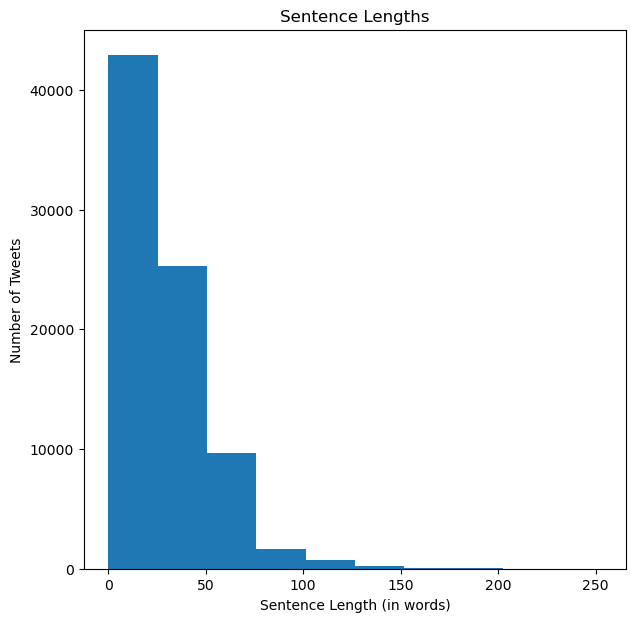

In [27]:
sentence_lengths = [len(tokens) for tokens in trading_hours_tweets['tokens']]
vocab = sorted(list(set([word for tokens in trading_hours_tweets['tokens'] for word in tokens])))

plt.figure(figsize = (7,7))
plt.xlabel('Sentence Length (in words)')
plt.ylabel('Number of Tweets')
plt.title('Sentence Lengths')
plt.hist(sentence_lengths)
plt.show()

In [28]:
print('We have a vocabulary size of', len(vocab), 'unique words')

We have a vocabulary size of 105368 unique words


### 3.2.5 Removing Stop Words

“Stop words” are the most common words in a language like “the”, “a”, “at”, “for”, “above”, “on”, “is”, “all”. These words do not provide any meaning and are usually removed from texts. We can remove these stop words using nltk library

In [29]:
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
trading_hours_tweets['tweet_without_stopwords'] = trading_hours_tweets['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
trading_hours_tweets.head()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,char_count,...,htag_count,mention_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,clean_text,tokens,tweet_without_stopwords
0,2022-10-04,20:29:10,BarbaraDarlin,0,Tweetbot for iÎS,.@apple needs to do this WORLDWIDE! https://t....,0.000000,0.000000,Neutral,59,...,0,0,"{'! count': 1, '"" count': 0, '# count': 0, '$ ...",8.428571,2.333333,1.000000,0.428571,need to do thi worldwide http t co zlitq...,"[need, to, do, thi, worldwide, http, t, co, zl...",need thi worldwide http co zlitq pich
1,2022-10-04,20:29:03,Options,0,StockTwits Web,"#HotOptions Report For End Of Day, October 4, ...",0.000000,0.000000,Neutral,207,...,0,0,"{'! count': 0, '"" count': 0, '# count': 1, '$ ...",6.900000,30.000000,1.000000,0.000000,hotoption report for end of day october ...,"[hotoption, report, for, end, of, day, october...",hotoption report end day october â la aapl a...
2,2022-10-04,20:27:59,IGSquawk,8,TweetDeck,FANG+ Constituents:\n\n$AAPL 146.04 +2.52%\n$A...,0.000000,0.000000,Neutral,238,...,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",6.800000,35.000000,1.000000,0.000000,fang con tituent \n\n aapl \n amzn ...,"[fang, con, tituent, aapl, amzn, baba, bidu, m...",fang con tituent aapl amzn baba bidu meta goog...
3,2022-10-04,20:27:54,breckyunits,0,Twitter Web App,I gave this talk in 2017 at @forwardJS . They ...,0.633333,-0.366667,Negative,229,...,0,0,"{'! count': 0, '"" count': 2, '# count': 0, '$ ...",5.871795,9.750000,0.923077,0.384615,i gave thi talk in at they had it profe i...,"[i, gave, thi, talk, in, at, they, had, it, pr...",gave thi talk profe ionally recorded thought w...
4,2022-10-04,20:27:11,emilesmithjoe,0,Twitter for iPhone,@Apple make a cannon emoji. Thank you,0.000000,0.000000,Neutral,37,...,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",5.285714,3.500000,1.000000,0.285714,make a cannon emoji thank you,"[make, a, cannon, emoji, thank, you]",make cannon emoji thank


### 3.2.6 Lemmitization

In simpler terms, lemmitization is the process of converting a word to its base form. Lemmatization considers the context and converts the word to its meaningful base form. For example, lemmatization would correctly identify the base form of ‘caring’ to ‘care'. This is extremely valuable because we want to identify key words that lead to negative, positive and neutral sentiments.

In [30]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

trading_hours_tweets['tweet_lemmatized'] = trading_hours_tweets['tweet_without_stopwords'].apply(lemmatize_text)
trading_hours_tweets.head()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,char_count,...,mention_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,clean_text,tokens,tweet_without_stopwords,tweet_lemmatized
0,2022-10-04,20:29:10,BarbaraDarlin,0,Tweetbot for iÎS,.@apple needs to do this WORLDWIDE! https://t....,0.000000,0.000000,Neutral,59,...,0,"{'! count': 1, '"" count': 0, '# count': 0, '$ ...",8.428571,2.333333,1.000000,0.428571,need to do thi worldwide http t co zlitq...,"[need, to, do, thi, worldwide, http, t, co, zl...",need thi worldwide http co zlitq pich,"[need, thi, worldwide, http, co, zlitq, pich]"
1,2022-10-04,20:29:03,Options,0,StockTwits Web,"#HotOptions Report For End Of Day, October 4, ...",0.000000,0.000000,Neutral,207,...,0,"{'! count': 0, '"" count': 0, '# count': 1, '$ ...",6.900000,30.000000,1.000000,0.000000,hotoption report for end of day october ...,"[hotoption, report, for, end, of, day, october...",hotoption report end day october â la aapl a...,"[hotoption, report, end, day, october, â, la..."
2,2022-10-04,20:27:59,IGSquawk,8,TweetDeck,FANG+ Constituents:\n\n$AAPL 146.04 +2.52%\n$A...,0.000000,0.000000,Neutral,238,...,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",6.800000,35.000000,1.000000,0.000000,fang con tituent \n\n aapl \n amzn ...,"[fang, con, tituent, aapl, amzn, baba, bidu, m...",fang con tituent aapl amzn baba bidu meta goog...,"[fang, con, tituent, aapl, amzn, baba, bidu, m..."
3,2022-10-04,20:27:54,breckyunits,0,Twitter Web App,I gave this talk in 2017 at @forwardJS . They ...,0.633333,-0.366667,Negative,229,...,0,"{'! count': 0, '"" count': 2, '# count': 0, '$ ...",5.871795,9.750000,0.923077,0.384615,i gave thi talk in at they had it profe i...,"[i, gave, thi, talk, in, at, they, had, it, pr...",gave thi talk profe ionally recorded thought w...,"[gave, thi, talk, profe, ionally, recorded, th..."
4,2022-10-04,20:27:11,emilesmithjoe,0,Twitter for iPhone,@Apple make a cannon emoji. Thank you,0.000000,0.000000,Neutral,37,...,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",5.285714,3.500000,1.000000,0.285714,make a cannon emoji thank you,"[make, a, cannon, emoji, thank, you]",make cannon emoji thank,"[make, cannon, emoji, thank]"


## 3.3 TF-IDF 

We will first try the TF-IDF method. TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify words in a set of documents. We generally compute a score for each word to signify its importance in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining.

### 3.3.1 Train/Test Split

## 3.4 Embedding

Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. Loosely speaking, they are vector representations of a particular word. In this project, we will use Word2Vec embedding method to map a word to a fixed-length vector. In simple terms, words that have similar meanings or are related closely, when mapped into a vector space would appear closer, like in a cluster. This can help us understand the semantics of the words in a sentence better than any previously mentioned technique. 

Word2Vec utilizes two architectures :

**CBOW (Continuous Bag of Words)**: CBOW model predicts the current word given context words within a specific window. The input layer contains the context words and the output layer contains the current word. The hidden layer contains the number of dimensions in which we want to represent the current word present at the output layer. 

**Skip Gram** : Skip gram predicts the surrounding context words within specific window given current word. The input layer contains the current word and the output layer contains the context words. The hidden layer contains the number of dimensions in which we want to represent current word present at the input layer.

Challenges \
Word2Vec cannot handle out of vocabulary words very well. \
Doesn’t take the context of the word into account. \ 
Requires fairly large corpus to train on. \ 

### 3.4.1 Data Preparation